### **Universidade Federal do Rio Grande do Norte - UFRN**

### **Programa de Pós Graduação em Engenharia Elétrica e de Computação - PPgEEC**

### PPGEEC 2327 - Tópicos Especiais em Processamento Inteligente da Informação

#### Docente: Tiago Tavares Leite Barros

#### Discente: Matheus Gomes Diniz Andrade


# Importing

In [1]:
import warnings
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch.nn.functional as F

from utils.metrics import evaluate

from torchinfo import summary


In [2]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

# Aquisição dos Dados

In [3]:
data = pd.read_csv('../data/co2.csv')

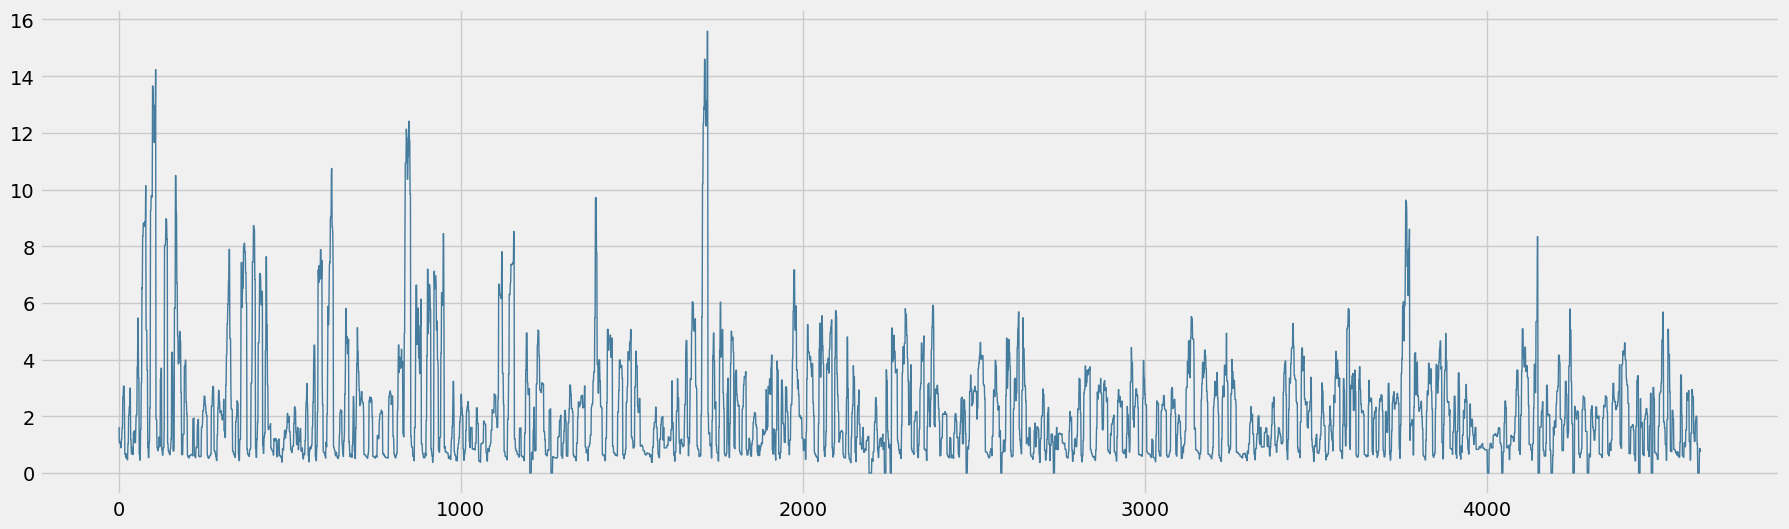

In [4]:
plt.figure(figsize=(20, 6))

plt.plot(data, linewidth=1, color="#457B9D")

plt.show()

# Preparação dos Dados

In [5]:
test_size = int(len(data) * 0.2)
train_data = data[:-test_size]
test_data = data[-test_size:]

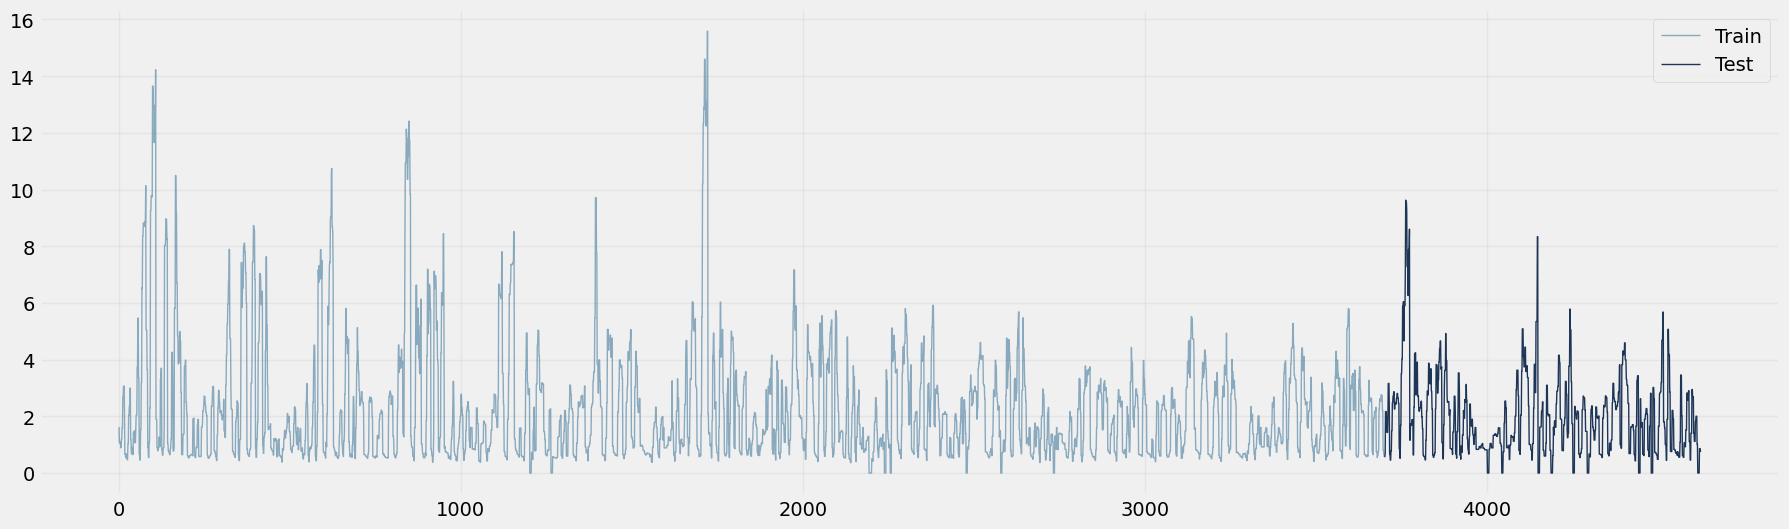

In [6]:
train_range = np.arange(len(train_data["co2"]))
test_range = np.arange(len(train_data["co2"]), len(train_data["co2"]) + len(test_data["co2"]))

plt.figure(figsize=(20, 6))

plt.plot(train_range, train_data["co2"], label='Train', color='#457B9D', alpha=0.6, linewidth=1)

plt.plot(test_range, test_data["co2"], label='Test', color='#1D3557', linewidth=1)

plt.ylabel("")

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data)

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [8]:
train_normalized = scaler.transform(train_data)
test_normalized = scaler.transform(test_data)

In [9]:
def create_sequences(data, seq_length):
    xs, ys = [], []

    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [10]:
shift_size = 5

In [11]:
X_train, y_train = create_sequences(train_normalized, shift_size)
X_test, y_test = create_sequences(test_normalized, shift_size)

In [12]:
X_train_tensor = torch.from_numpy(X_train).reshape(-1, shift_size, 1).float()
y_train_tensor = torch.from_numpy(y_train).reshape(-1, 1).float()

X_test_tensor = torch.from_numpy(X_test).reshape(-1, shift_size, 1).float()
y_test_tensor = torch.from_numpy(y_test).reshape(-1, 1).float()

# Definição do Modelo

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self, input_size=1, output_size=1, num_channels=32):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_channels, kernel_size=3, padding=1)
        
        self.conv2 = nn.Conv1d(in_channels=num_channels, out_channels=num_channels * 2, kernel_size=3, padding=1)
        
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        
        self.flatten = nn.Flatten()
        
        self.fc = nn.Linear(num_channels * 2, output_size)

    def forward(self, x):
        # Permuta para o formato da Conv1d: (batch_size, input_size, seq_length)
        x = x.permute(0, 2, 1) 
        
        x = F.relu(self.conv1(x))
        
        x = F.relu(self.conv2(x))
        
        x = self.global_avg_pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        
        return x

In [14]:
input_size = 1
output_size = 1
num_epochs = 200
learning_rate = 0.005

model_cnn = SimpleCNN(input_size=input_size, output_size=output_size)

In [15]:
model_cnn_summary = summary(
    model_cnn, 
    input_size=(1, shift_size, input_size),
    col_names=["input_size", "output_size", "num_params", "kernel_size"],
    verbose=1
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
SimpleCNN                                [1, 5, 1]                 [1, 1]                    --                        --
├─Conv1d: 1-1                            [1, 1, 5]                 [1, 32, 5]                128                       [3]
├─Conv1d: 1-2                            [1, 32, 5]                [1, 64, 5]                6,208                     [3]
├─AdaptiveAvgPool1d: 1-3                 [1, 64, 5]                [1, 64, 1]                --                        --
├─Flatten: 1-4                           [1, 64, 1]                [1, 64]                   --                        --
├─Linear: 1-5                            [1, 64]                   [1, 1]                    65                        --
Total params: 6,401
Trainable params: 6,401
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.03
Input size (MB): 0.00
Forw

In [16]:
num_epochs = 200
learning_rate = 0.005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model_cnn.train()

    outputs = model_cnn(X_train_tensor)
    optimizer.zero_grad()

    loss = criterion(outputs, y_train_tensor)

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    with torch.no_grad():
        test_out = model_cnn(X_test_tensor)
        test_loss = criterion(test_out, y_test_tensor)

        test_losses.append(test_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [10/200], Loss: 0.011339
Epoch [20/200], Loss: 0.007284
Epoch [30/200], Loss: 0.007066
Epoch [40/200], Loss: 0.006500
Epoch [50/200], Loss: 0.005919
Epoch [60/200], Loss: 0.005069
Epoch [70/200], Loss: 0.003990
Epoch [80/200], Loss: 0.003381
Epoch [90/200], Loss: 0.003360
Epoch [100/200], Loss: 0.003247
Epoch [110/200], Loss: 0.003158
Epoch [120/200], Loss: 0.003078
Epoch [130/200], Loss: 0.003001
Epoch [140/200], Loss: 0.002929
Epoch [150/200], Loss: 0.002864
Epoch [160/200], Loss: 0.002826
Epoch [170/200], Loss: 0.002823
Epoch [180/200], Loss: 0.002790
Epoch [190/200], Loss: 0.002762
Epoch [200/200], Loss: 0.002748


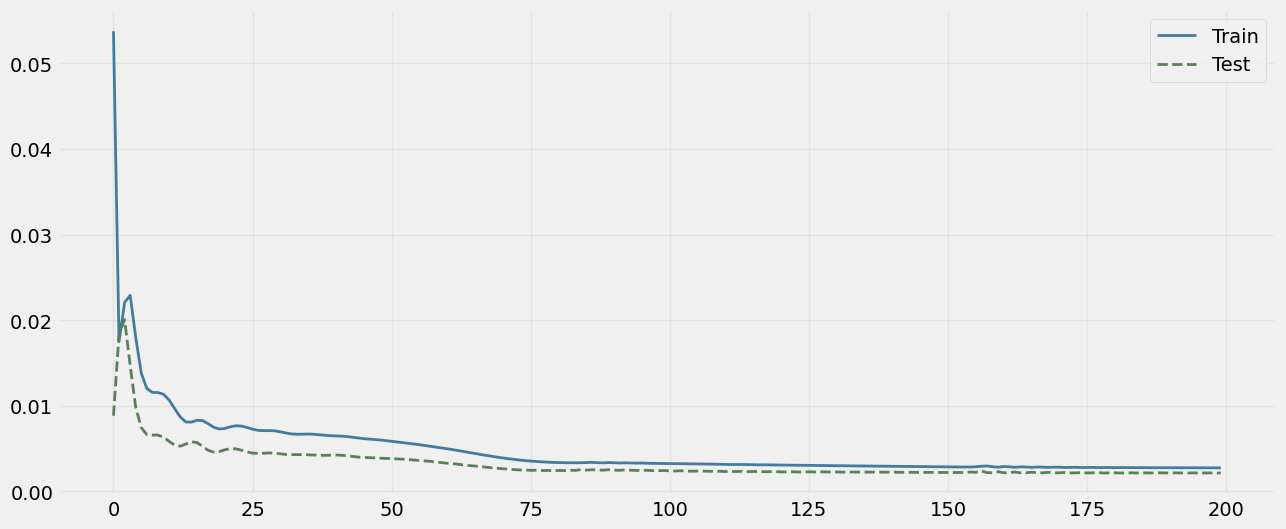

In [17]:
plt.figure(figsize=(14, 6))

plt.plot(train_losses, label='Train', color='#457B9D', linewidth=2)
plt.plot(test_losses, label='Test', color='#588157', linestyle='--', linewidth=2)

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [18]:
model_cnn.eval()

start_time_cnn = time.time()

with torch.no_grad():
    predictions_normalized = model_cnn(X_test_tensor.float())

end_time_cnn = time.time()

predictions_normalized = predictions_normalized.cpu().numpy()
y_test_normalized = y_test_tensor.cpu().numpy()

predictions_real = scaler.inverse_transform(predictions_normalized)
y_test_real = scaler.inverse_transform(y_test_normalized)

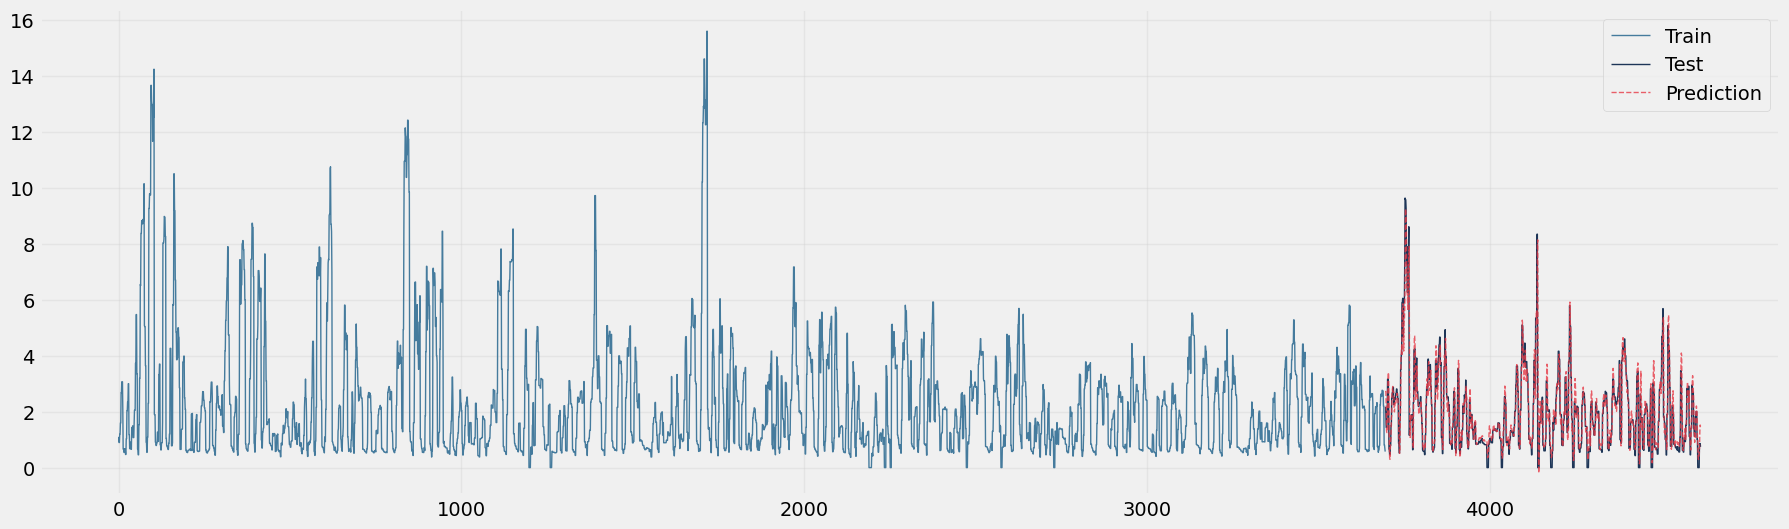

In [19]:
y_train_real = scaler.inverse_transform(y_train_tensor.cpu().numpy())

train_range = np.arange(len(y_train))
test_range = np.arange(len(y_train), len(y_train) + len(y_test_real))

plt.figure(figsize=(20, 6))

plt.plot(train_range, y_train_real, label='Train', color='#457B9D', linewidth=1)
plt.plot(test_range, y_test_real, label='Test', color='#1D3557', linewidth=1)
plt.plot(test_range, predictions_real, label='Prediction', color='#E63946', alpha=0.8, linestyle='--', linewidth=1)

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [20]:
pd.DataFrame(evaluate(y_test_real, predictions_real), index=[0])

,mae,rmse,r2
0,0.420745,0.72289,0.759579


In [21]:
total_time_cnn = end_time_cnn - start_time_cnn
avg_time_per_step_cnn = total_time_cnn / len(X_test_tensor)

avg_time_per_step_cnn

1.516860464344854e-05

In [22]:
input_size = 1
output_size = 1
num_epochs = 200
learning_rate = 0.005

model_cnn = SimpleCNN(input_size=input_size, output_size=output_size, num_channels=64)

In [23]:
model_cnn_summary = summary(
    model_cnn, 
    input_size=(1, shift_size, input_size),
    col_names=["input_size", "output_size", "num_params", "kernel_size"],
    verbose=1
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
SimpleCNN                                [1, 5, 1]                 [1, 1]                    --                        --
├─Conv1d: 1-1                            [1, 1, 5]                 [1, 64, 5]                256                       [3]
├─Conv1d: 1-2                            [1, 64, 5]                [1, 128, 5]               24,704                    [3]
├─AdaptiveAvgPool1d: 1-3                 [1, 128, 5]               [1, 128, 1]               --                        --
├─Flatten: 1-4                           [1, 128, 1]               [1, 128]                  --                        --
├─Linear: 1-5                            [1, 128]                  [1, 1]                    129                       --
Total params: 25,089
Trainable params: 25,089
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.12
Input size (MB): 0.00
Fo

In [24]:
num_epochs = 200
learning_rate = 0.005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model_cnn.train()

    outputs = model_cnn(X_train_tensor)
    optimizer.zero_grad()

    loss = criterion(outputs, y_train_tensor)

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    with torch.no_grad():
        test_out = model_cnn(X_test_tensor)
        test_loss = criterion(test_out, y_test_tensor)

        test_losses.append(test_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [10/200], Loss: 0.020523
Epoch [20/200], Loss: 0.009690
Epoch [30/200], Loss: 0.006709
Epoch [40/200], Loss: 0.005370
Epoch [50/200], Loss: 0.004481
Epoch [60/200], Loss: 0.003732
Epoch [70/200], Loss: 0.003411
Epoch [80/200], Loss: 0.003304
Epoch [90/200], Loss: 0.003231
Epoch [100/200], Loss: 0.003182
Epoch [110/200], Loss: 0.003139
Epoch [120/200], Loss: 0.003095
Epoch [130/200], Loss: 0.003053
Epoch [140/200], Loss: 0.003013
Epoch [150/200], Loss: 0.002975
Epoch [160/200], Loss: 0.002938
Epoch [170/200], Loss: 0.002902
Epoch [180/200], Loss: 0.002868
Epoch [190/200], Loss: 0.002833
Epoch [200/200], Loss: 0.002799


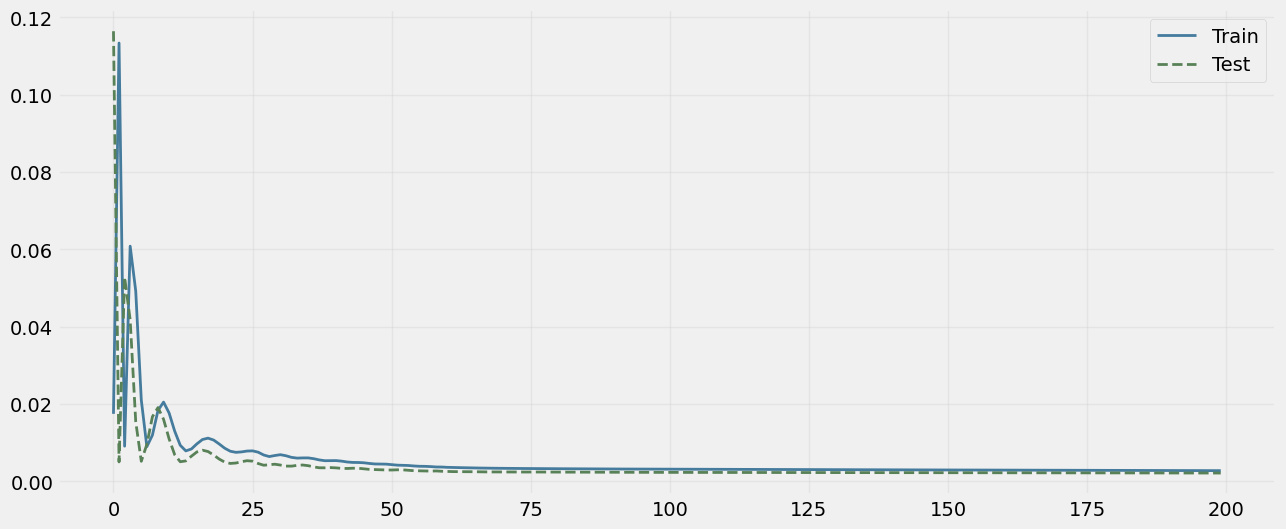

In [25]:
plt.figure(figsize=(14, 6))

plt.plot(train_losses, label='Train', color='#457B9D', linewidth=2)
plt.plot(test_losses, label='Test', color='#588157', linestyle='--', linewidth=2)

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [26]:
model_cnn.eval()

start_time_cnn = time.time()

with torch.no_grad():
    predictions_normalized = model_cnn(X_test_tensor.float())

end_time_cnn = time.time()

predictions_normalized = predictions_normalized.cpu().numpy()
y_test_normalized = y_test_tensor.cpu().numpy()

predictions_real = scaler.inverse_transform(predictions_normalized)
y_test_real = scaler.inverse_transform(y_test_normalized)

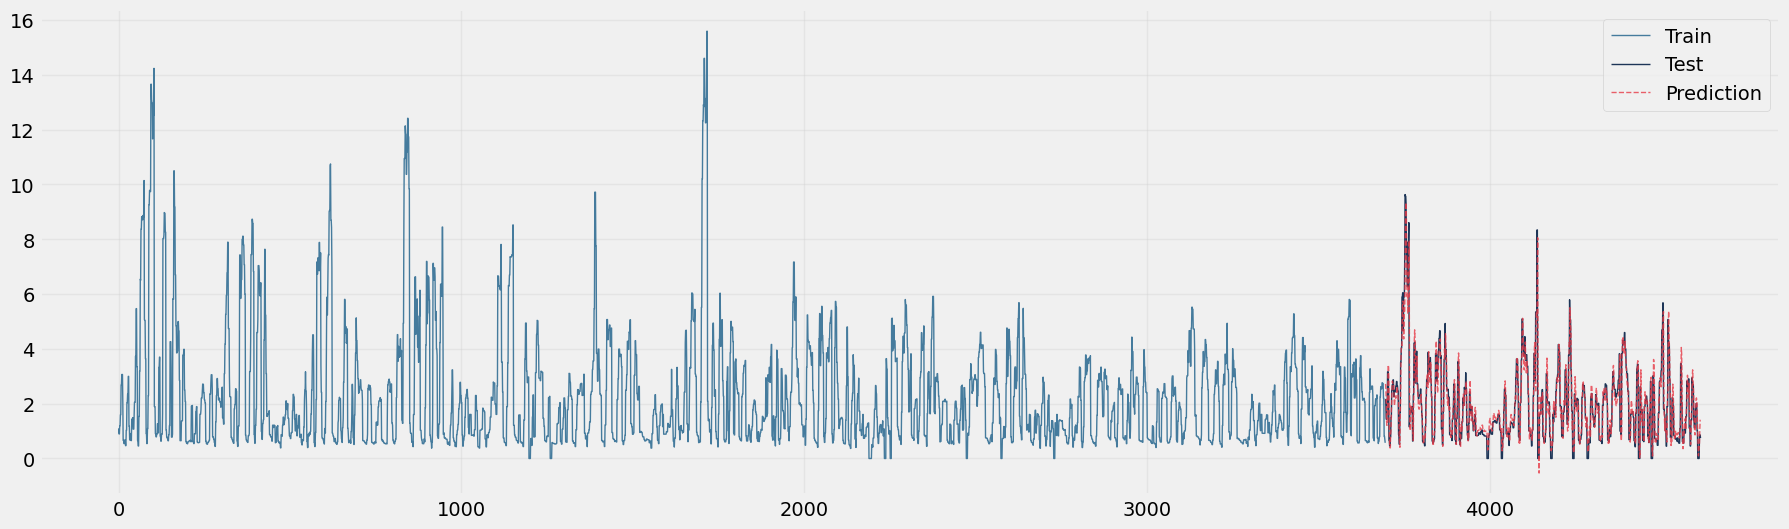

In [27]:
y_train_real = scaler.inverse_transform(y_train_tensor.cpu().numpy())

train_range = np.arange(len(y_train))
test_range = np.arange(len(y_train), len(y_train) + len(y_test_real))

plt.figure(figsize=(20, 6))

plt.plot(train_range, y_train_real, label='Train', color='#457B9D', linewidth=1)
plt.plot(test_range, y_test_real, label='Test', color='#1D3557', linewidth=1)
plt.plot(test_range, predictions_real, label='Prediction', color='#E63946', alpha=0.8, linestyle='--', linewidth=1)

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [28]:
pd.DataFrame(evaluate(y_test_real, predictions_real), index=[0])

,mae,rmse,r2
0,0.429583,0.727231,0.756683


In [29]:
total_time_cnn = end_time_cnn - start_time_cnn
avg_time_per_step_cnn = total_time_cnn / len(X_test_tensor)

avg_time_per_step_cnn

1.9604226817255435e-05

In [30]:
input_size = 1
output_size = 1
num_epochs = 200
learning_rate = 0.005

model_cnn = SimpleCNN(input_size=input_size, output_size=output_size, num_channels=128)

In [31]:
model_cnn_summary = summary(
    model_cnn, 
    input_size=(1, shift_size, input_size),
    col_names=["input_size", "output_size", "num_params", "kernel_size"],
    verbose=1
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
SimpleCNN                                [1, 5, 1]                 [1, 1]                    --                        --
├─Conv1d: 1-1                            [1, 1, 5]                 [1, 128, 5]               512                       [3]
├─Conv1d: 1-2                            [1, 128, 5]               [1, 256, 5]               98,560                    [3]
├─AdaptiveAvgPool1d: 1-3                 [1, 256, 5]               [1, 256, 1]               --                        --
├─Flatten: 1-4                           [1, 256, 1]               [1, 256]                  --                        --
├─Linear: 1-5                            [1, 256]                  [1, 1]                    257                       --
Total params: 99,329
Trainable params: 99,329
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.50
Input size (MB): 0.00
Fo

In [32]:
num_epochs = 200
learning_rate = 0.005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model_cnn.train()

    outputs = model_cnn(X_train_tensor)
    optimizer.zero_grad()

    loss = criterion(outputs, y_train_tensor)

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    with torch.no_grad():
        test_out = model_cnn(X_test_tensor)
        test_loss = criterion(test_out, y_test_tensor)

        test_losses.append(test_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [10/200], Loss: 0.052598
Epoch [20/200], Loss: 0.021221
Epoch [30/200], Loss: 0.014270
Epoch [40/200], Loss: 0.009602
Epoch [50/200], Loss: 0.007189
Epoch [60/200], Loss: 0.006953
Epoch [70/200], Loss: 0.006381
Epoch [80/200], Loss: 0.005917
Epoch [90/200], Loss: 0.004634
Epoch [100/200], Loss: 0.003163
Epoch [110/200], Loss: 0.002806
Epoch [120/200], Loss: 0.002795
Epoch [130/200], Loss: 0.002744
Epoch [140/200], Loss: 0.002723
Epoch [150/200], Loss: 0.002709
Epoch [160/200], Loss: 0.002697
Epoch [170/200], Loss: 0.002687
Epoch [180/200], Loss: 0.002679
Epoch [190/200], Loss: 0.002671
Epoch [200/200], Loss: 0.002664


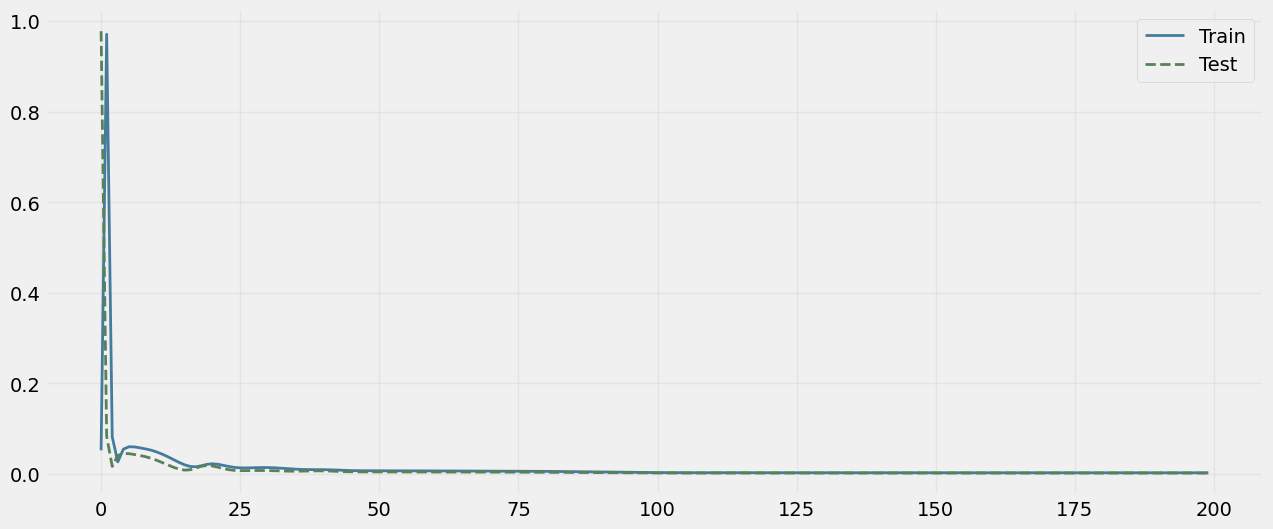

In [33]:
plt.figure(figsize=(14, 6))

plt.plot(train_losses, label='Train', color='#457B9D', linewidth=2)
plt.plot(test_losses, label='Test', color='#588157', linestyle='--', linewidth=2)

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [34]:
model_cnn.eval()

start_time_cnn = time.time()

with torch.no_grad():
    predictions_normalized = model_cnn(X_test_tensor.float())

end_time_cnn = time.time()

predictions_normalized = predictions_normalized.cpu().numpy()
y_test_normalized = y_test_tensor.cpu().numpy()

predictions_real = scaler.inverse_transform(predictions_normalized)
y_test_real = scaler.inverse_transform(y_test_normalized)

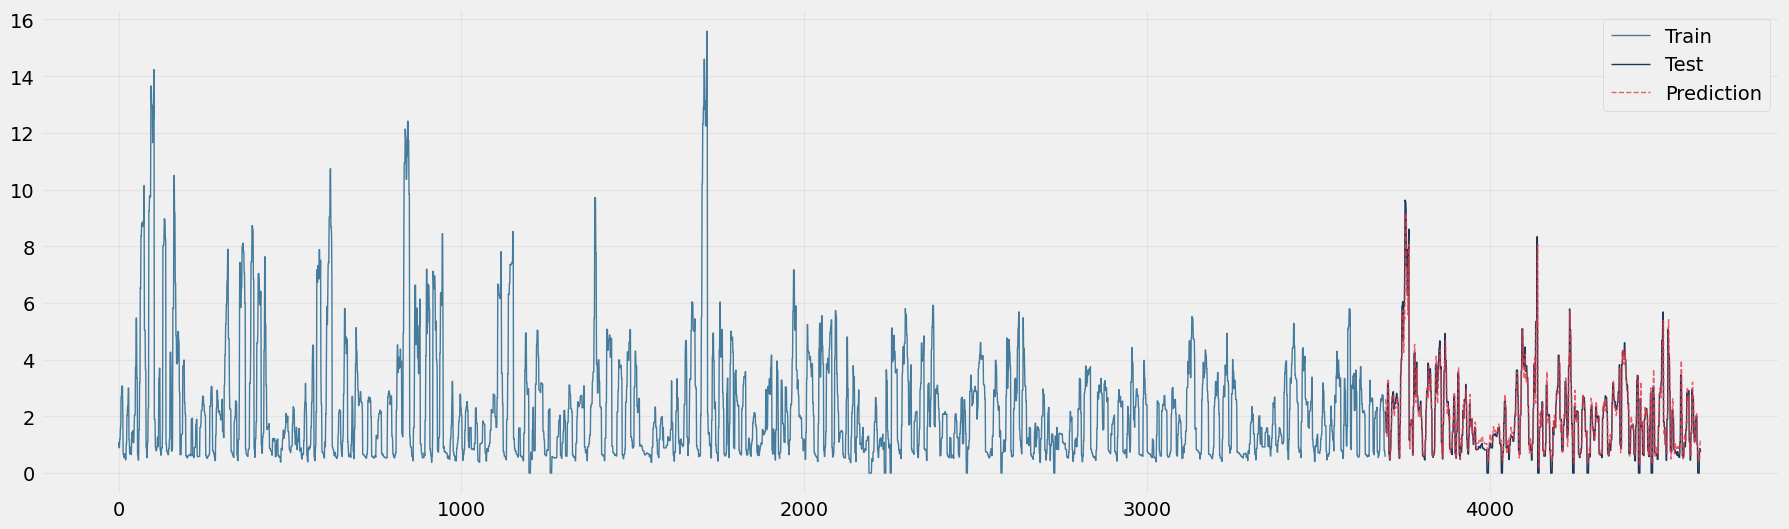

In [35]:
y_train_real = scaler.inverse_transform(y_train_tensor.cpu().numpy())

train_range = np.arange(len(y_train))
test_range = np.arange(len(y_train), len(y_train) + len(y_test_real))

plt.figure(figsize=(20, 6))

plt.plot(train_range, y_train_real, label='Train', color='#457B9D', linewidth=1)
plt.plot(test_range, y_test_real, label='Test', color='#1D3557', linewidth=1)
plt.plot(test_range, predictions_real, label='Prediction', color='#E63946', alpha=0.8, linestyle='--', linewidth=1)

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [36]:
pd.DataFrame(evaluate(y_test_real, predictions_real), index=[0])

,mae,rmse,r2
0,0.404149,0.711588,0.767038


In [37]:
total_time_cnn = end_time_cnn - start_time_cnn
avg_time_per_step_cnn = total_time_cnn / len(X_test_tensor)

avg_time_per_step_cnn

6.581182065217391e-05

In [38]:
# pd.DataFrame(evaluate(y_test_real, predictions_real), index=[0]).to_csv("./results/02_cnn.csv", index=False)